In [32]:
import os

from huggingface_hub import login
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
from transformers import BertTokenizer, XLMRobertaTokenizerFast
from tqdm import tqdm

In [3]:
# authentication with huggingface
# !pip install ipywidgets
# request data access at https://huggingface.co/datasets/Cofacts/line-msg-fact-check-tw
# create token at https://huggingface.co/settings/tokens (create as read)
# token should be stored locally, so technically login is only needed one time
login()

In [4]:
# download specific dataset files; entire archive is only ~250 mb
articles = load_dataset("Cofacts/line-msg-fact-check-tw", "articles") # article contents and some meta info
article_replies = load_dataset("Cofacts/line-msg-fact-check-tw", "article_replies") # 'join table' for articles and replies with added meta info

In [5]:
art_rep_df = pd.merge(articles["train"].to_pandas(), article_replies["train"].to_pandas(), left_on="id", right_on="articleId", how="left")
art_rep_df.head()
# replyType is the label assigned to the article by the human editor

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,articleId,replyId,userIdsha256_y,negativeFeedbackCount,positiveFeedbackCount,replyType,appId_y,status_y,createdAt_y,updatedAt_y
0,14h550ymn3m3u,TEXT,NORMAL,BA.5病毒引發的不只「縮短潛伏期，增加R0值」，還有易使人「再感染（Reinfecion）...,1.0,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.381Z,3753ca22ca96f5fc1f13e62291f28e405d56b1a976b21d...,RUMORS_LINE_BOT,...,14h550ymn3m3u,6oo8DYMBv5it-Cx_8405,6892d0026181e95d034bf8781025afbf395d57cc88ac05...,0.0,3.0,RUMOR,WEBSITE,NORMAL,2022-09-05T10:40:41.789Z,2022-09-05T10:40:41.789Z
1,326xjpkjbf01i,TEXT,NORMAL,https://youtu.be/xK9NzL3PkdE,0.0,2022-09-08T12:34:27.602Z,2022-09-08T12:34:27.602Z,2022-09-08T12:34:27.634Z,243b5897c14f02fb5b92a9e4f4cc39d5fb84ff16173add...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,oupi0eu9aocr,TEXT,NORMAL,被取消的航班\n\n2018年的一天，我從洛杉磯回國，乘坐凌晨一點的國航航班，馬上要登機了，...,1.0,2021-11-13T16:36:56.548Z,2021-11-13T16:36:56.548Z,2022-04-27T08:52:17.115Z,4a266a6fdefc88e59eef644402e97c7f4c8196becca686...,RUMORS_LINE_BOT,...,oupi0eu9aocr,MYotCYMBv5it-Cx_gIpH,fc9652aa205dab75e19ecff420945e95aa3909a54b0d9a...,0.0,1.0,OPINIONATED,WEBSITE,NORMAL,2022-09-04T15:45:20.464Z,2022-09-04T15:45:20.464Z
3,my5ep5z69tql,TEXT,NORMAL,你好👱🏻‍♀️\n\n簡單跟你說一下公司工作內容：\n我們是做購物系統訂單的工作，主要就是增...,1.0,2022-08-11T20:53:15.644Z,2022-08-11T20:53:15.644Z,2022-09-07T11:02:00.344Z,8a8a319bea0b3bff580d8507ae6470ba37e87791171886...,RUMORS_LINE_BOT,...,my5ep5z69tql,y22DlmsBFV14knB4ErTJ,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T22:59:48.921Z,2022-09-07T22:59:48.921Z
4,3dnh713ikpf3c,TEXT,NORMAL,先和你簡單介紹\n我們誠徵線上打工小幫手\n工作內容有：聽寫打字、頁面排版、商品評論刷流量、...,1.0,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.761Z,47e90b2538a5615b323f50571b77d91f7f105e55684aa1...,RUMORS_LINE_BOT,...,3dnh713ikpf3c,H8Hz4WsBqwaEkHKwtyFm,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T23:00:19.207Z,2022-09-07T23:00:19.207Z


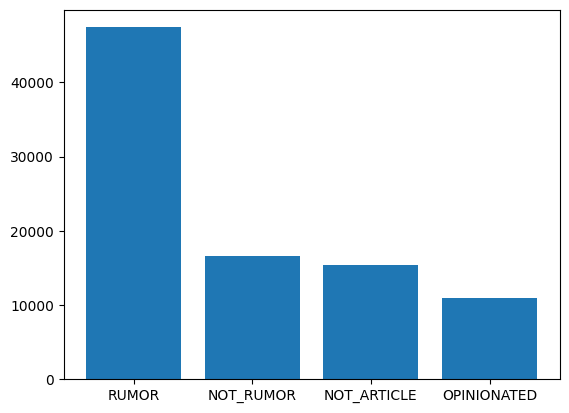

replyType
RUMOR          47408
NOT_RUMOR      16613
NOT_ARTICLE    15430
OPINIONATED    10955
Name: count, dtype: int64


In [6]:
# imbalance
cat_counts = art_rep_df["replyType"].value_counts()
plt.bar(cat_counts.index, cat_counts.values)
plt.show()
print(cat_counts)

In [7]:
def get_max_length(texts: list):
    max_length = 0
    for t in texts:
        if t:
            max_length = max(max_length, len(t))
    return max_length

def inspect_dist(col: list, threshold = 0):
    if threshold == 0:
        plt.hist(col, bins=100)
        plt.show()
    else:
        plt.hist(col[col <= threshold], bins=100)
        plt.show()
        print(f"Remaining datapoints: {len(col[col <= threshold]) / len(col)}")

In [8]:
get_max_length(art_rep_df["text"])

10037

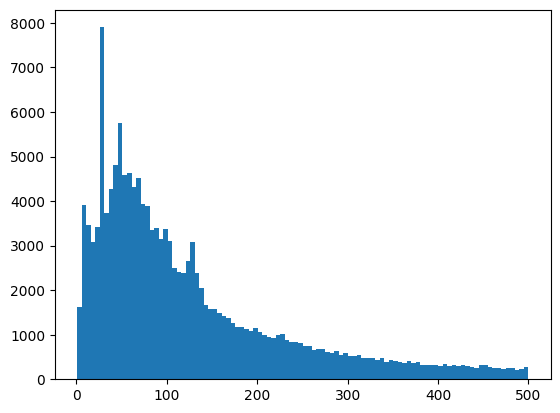

Remaining datapoints: 0.878993991129763


In [9]:
inspect_dist(art_rep_df["text"].dropna().apply(len), threshold=500)

In [10]:
art_rep_df[art_rep_df["text"].str.len() == 28]
# NOTE: remove urls

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,articleId,replyId,userIdsha256_y,negativeFeedbackCount,positiveFeedbackCount,replyType,appId_y,status_y,createdAt_y,updatedAt_y
1,326xjpkjbf01i,TEXT,NORMAL,https://youtu.be/xK9NzL3PkdE,0.0,2022-09-08T12:34:27.602Z,2022-09-08T12:34:27.602Z,2022-09-08T12:34:27.634Z,243b5897c14f02fb5b92a9e4f4cc39d5fb84ff16173add...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,2ihx6b0hy6reh,TEXT,NORMAL,https://fb.watch/fqyCukx77O/,0.0,2022-09-09T08:30:45.294Z,2022-09-09T08:30:45.294Z,2022-09-09T08:30:45.321Z,67cb002cbd4884b64f03aca3400e67a867b35e3838caa3...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,2zvytlna89voa,TEXT,NORMAL,https://youtu.be/EHvxmzP7Mfw,0.0,2022-09-11T00:24:14.167Z,2022-09-11T00:24:14.167Z,2022-09-11T00:24:14.197Z,1b8841d66c76e5ebbce83a71ddfa61fea29c32a736218f...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,32745wxu27y2q,TEXT,NORMAL,https://youtu.be/BSh2Lj_OrDs,0.0,2022-09-11T06:24:59.763Z,2022-09-11T06:24:59.763Z,2022-09-11T06:24:59.791Z,9fdd5c5952dbbe145c4f00ca018fe0979e5875fbac45fe...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,1ppbai7d2l96o,TEXT,NORMAL,https://youtu.be/3nX_ctdukOI,0.0,2022-09-11T12:29:43.754Z,2022-09-11T12:29:43.754Z,2022-09-11T12:29:43.786Z,5e19fe6083cf02075ff2e022e526a4b09d4958780174d3...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168960,h9io4zcc5wbg,TEXT,NORMAL,了解 先自我介紹一下 我是淞瑋包裝材料行徵工代表：葉佳倩,1.0,2024-01-20T06:44:26.971Z,2024-01-20T06:44:26.971Z,2024-01-25T08:35:51.328Z,17295e1f0761fd28c74ff00632d2dd29dbf37baf42f8f0...,RUMORS_LINE_BOT,...,h9io4zcc5wbg,qPc9Qo0BAjOeMOklzqEu,7708d900e0a9d4a92ad69381b1e0782338787e027954ce...,0.0,0.0,RUMOR,WEBSITE,NORMAL,2024-01-25T20:09:23.249Z,2024-01-25T20:09:23.249Z
169040,3dl8g74u3exnz,TEXT,NORMAL,要去app sotre搜尋COINCENTEL載到桌布喔,0.0,2024-01-26T12:11:53.760Z,2024-01-26T12:11:53.760Z,2024-01-26T12:11:53.777Z,8ab6707dd0821b0605969c1bc0481d3ca0bbc87953c9ee...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169313,22vlxdwzs7l7d,TEXT,NORMAL,https://txp.rs/v/ACr5NfeCEn2,0.0,2024-01-26T06:04:22.281Z,2024-01-26T06:04:22.281Z,2024-01-26T06:04:22.293Z,63318d9d6b88b75fac18d8bdb41a5b38ffa759576210f3...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169315,ok8jtnk1pj9g,TEXT,NORMAL,https://youtu.be/UwtXzwckeWQ,0.0,2023-05-18T04:27:21.707Z,2023-05-18T04:27:21.707Z,2024-01-26T07:19:52.516Z,e87d917e34b761d233273ebd5cf339be6c92c0920ceafc...,RUMORS_LINE_BOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
no_nans = art_rep_df.dropna(subset=["text", "replyType"])
no_nans.info()
no_nans["replyType"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 89997 entries, 0 to 169901
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       89997 non-null  object 
 1   articleType              89997 non-null  object 
 2   status_x                 89997 non-null  object 
 3   text                     89997 non-null  object 
 4   normalArticleReplyCount  89997 non-null  float64
 5   createdAt_x              89932 non-null  object 
 6   updatedAt_x              89059 non-null  object 
 7   lastRequestedAt          89868 non-null  object 
 8   userIdsha256_x           85464 non-null  object 
 9   appId_x                  89997 non-null  object 
 10  references               89997 non-null  object 
 11  articleId                89997 non-null  object 
 12  replyId                  89997 non-null  object 
 13  userIdsha256_y           89997 non-null  object 
 14  negativeFeedbackCount    8

replyType
RUMOR          47119
NOT_RUMOR      16592
NOT_ARTICLE    15390
OPINIONATED    10896
Name: count, dtype: int64

In [12]:
get_max_length(no_nans["text"])

10000

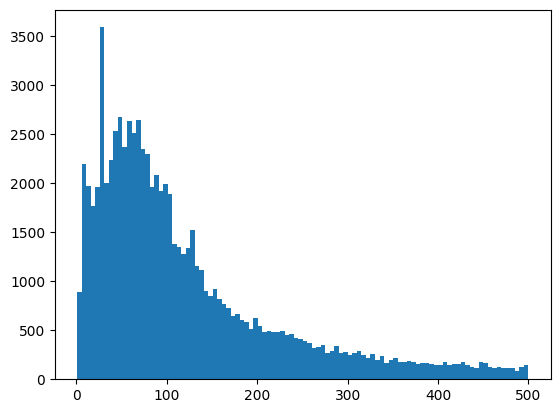

Remaining datapoints: 0.8774514706045757


In [13]:
inspect_dist(no_nans["text"].apply(len), threshold=500)

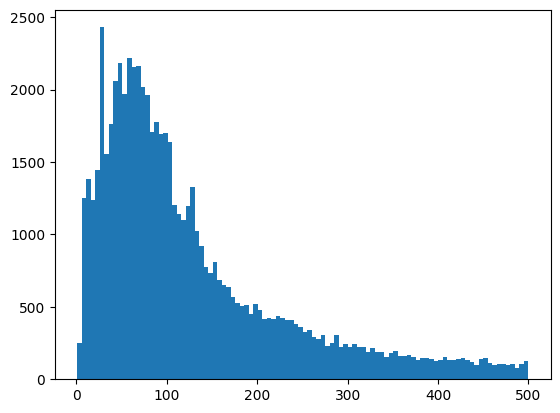

Remaining datapoints: 0.8685512083316579


In [14]:
filter_articles = no_nans[no_nans["replyType"] != "NOT_ARTICLE"]
inspect_dist(filter_articles["text"].apply(len), threshold=500)

In [15]:
filter_articles[filter_articles["text"].str.len() == 28]

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,articleId,replyId,userIdsha256_y,negativeFeedbackCount,positiveFeedbackCount,replyType,appId_y,status_y,createdAt_y,updatedAt_y
197,1rcpjlyyxj8z3,TEXT,NORMAL,https://youtu.be/dfkra9aWbUU,1.0,2022-08-22T14:50:41.179Z,2022-08-22T14:50:41.179Z,2022-08-23T12:16:58.136Z,5895588c4971a901a9cf4c7985cc6629737be6d3d5ca73...,RUMORS_LINE_BOT,...,1rcpjlyyxj8z3,popazYIBv5it-Cx_Q02L,86d6e7d770c3689556b9a1b392a3398e80ecf394762ffb...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-08-24T00:57:01.072Z,2022-08-24T00:57:01.072Z
240,2vrwlb2i18e0h,TEXT,NORMAL,你好！我是黑髮中醫師李君茹，请问你是想改善白发的症状吗？,1.0,2021-09-13T05:41:49.943Z,2021-09-13T05:41:49.943Z,2021-12-12T03:28:00.230Z,02ba17531c0858aa99ed8799d3acdead23366a6a9ad610...,RUMORS_LINE_BOT,...,2vrwlb2i18e0h,mEKGEXsBgBgcuemXMur5,096268ed177f92c93c962e612a6c59d86db8bb3867b245...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-09T05:18:38.241Z,2022-09-09T05:18:38.241Z
272,32n7ih4e4cabq,TEXT,NORMAL,https://youtu.be/cvy8Ha1iYr8,1.0,2022-08-20T07:44:34.482Z,2022-08-20T07:44:34.482Z,2022-08-20T07:44:34.509Z,71ce73705459f10b43999032195236d360194e188d6e81...,RUMORS_LINE_BOT,...,32n7ih4e4cabq,EIr5x4IBv5it-Cx_1kjw,86d6e7d770c3689556b9a1b392a3398e80ecf394762ffb...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-08-22T23:53:35.734Z,2022-08-22T23:53:35.734Z
361,2dri8uwzhq3cb,TEXT,NORMAL,https://www.xmtrader.net/tw/,1.0,2021-03-23T04:01:49.239Z,2021-03-23T04:01:49.239Z,2021-04-11T07:32:51.854Z,21dc43061a9de6579d38e0139db31978118e5e055e3f52...,RUMORS_LINE_BOT,...,2dri8uwzhq3cb,bVOJvIEBZ4FY5vnA3Y4I,86d6e7d770c3689556b9a1b392a3398e80ecf394762ffb...,0.0,2.0,RUMOR,WEBSITE,NORMAL,2022-07-02T01:32:40.589Z,2022-07-02T01:32:40.589Z
398,2i74ymhys5l85,TEXT,NORMAL,https://youtu.be/VWm--YH0U1s,1.0,2020-04-24T02:56:39.327Z,2020-04-24T02:56:39.327Z,2020-04-24T14:09:15.823Z,e8a78758ebbfb1cf5d53579664a763e2da8b31f2972226...,RUMORS_LINE_BOT,...,2i74ymhys5l85,bBS8rHEBrhVJn3LNfSS6,86d6e7d770c3689556b9a1b392a3398e80ecf394762ffb...,0.0,5.0,RUMOR,WEBSITE,NORMAL,2020-04-24T15:09:26.345Z,2020-04-24T15:09:26.345Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166011,2nn9hdhq0i5ds,TEXT,NORMAL,全世界都知道賴清德養小三叫莊雅芬、生了一個私生子叫賴庭瀚,1.0,2024-01-03T13:27:29.287Z,2024-01-03T13:27:29.287Z,2024-01-03T13:27:29.298Z,ba2fe1c2638275dde1c566a384aa2f4d9f88940ef61191...,RUMORS_LINE_BOT,...,2nn9hdhq0i5ds,5Pch1YwBAjOeMOklwxU3,d7a460c01f3f7bd926f40280e81445de0d72d2b140fe8b...,0.0,2.0,RUMOR,WEBSITE,NORMAL,2024-01-04T15:40:08.890Z,2024-01-04T15:40:08.890Z
166639,2ydtrd7w2lc8o,TEXT,NORMAL,https://youtu.be/2xO9PUcCcfs,1.0,2020-11-18T00:27:33.268Z,2020-11-18T00:27:33.268Z,2020-11-18T00:27:58.030Z,9fac7663bdb9f34bbee84ce9fd79b766b809e8710bf99b...,RUMORS_LINE_BOT,...,2ydtrd7w2lc8o,8Tqn22UBbZnN2I-EV51z,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,15.0,OPINIONATED,WEBSITE,NORMAL,2020-11-18T03:10:27.661Z,2020-11-18T03:10:27.661Z
167782,PPd8BY0BAjOeMOklr1aF,VIDEO,NORMAL,賴清德一樣\n柯文哲一樣\n誒那個柯文哲怎麼記下那個賴清德呢,1.0,2024-01-14T01:01:13.987Z,2024-01-14T01:01:13.987Z,2024-01-14T01:01:13.999Z,dc9571b65d738aa7ecf0c6367a7cc3a43103807f8df716...,RUMORS_LINE_BOT,...,PPd8BY0BAjOeMOklr1aF,Q_exBo0BAjOeMOkliliq,fd3e3b1b26903227de9cd115a3f89e3c2a1fbb60d2252c...,0.0,0.0,RUMOR,WEBSITE,NORMAL,2024-01-14T06:38:35.181Z,2024-01-14T06:38:35.181Z
168960,h9io4zcc5wbg,TEXT,NORMAL,了解 先自我介紹一下 我是淞瑋包裝材料行徵工代表：葉佳倩,1.0,2024-01-20T06:44:26.971Z,2024-01-20T06:44:26.971Z,2024-01-25T08:35:51.328Z,17295e1f0761fd28c74ff00632d2dd29dbf37baf42f8f0...,RUMORS_LINE_BOT,...,h9io4zcc5wbg,qPc9Qo0BAjOeMOklzqEu,7708d900e0a9d4a92ad69381b1e0782338787e027954ce...,0.0,0.0,RUMOR,WEBSITE,NORMAL,2024-01-25T20:09:23.249Z,2024-01-25T20:09:23.249Z


In [37]:
def remove_url(text: str):
    text = re.sub(r"https?://(?:www\.)?\w+(?:\.\w+)+(?:/\S*)?", "", text)
    if len(text) == 0:
        text = pd.NA
    return text

In [38]:
no_urls = filter_articles.copy()
no_urls["text"] = no_urls["text"].apply(remove_url)
no_urls.head()

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,articleId,replyId,userIdsha256_y,negativeFeedbackCount,positiveFeedbackCount,replyType,appId_y,status_y,createdAt_y,updatedAt_y
0,14h550ymn3m3u,TEXT,NORMAL,BA.5病毒引發的不只「縮短潛伏期，增加R0值」，還有易使人「再感染（Reinfecion）...,1.0,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.381Z,3753ca22ca96f5fc1f13e62291f28e405d56b1a976b21d...,RUMORS_LINE_BOT,...,14h550ymn3m3u,6oo8DYMBv5it-Cx_8405,6892d0026181e95d034bf8781025afbf395d57cc88ac05...,0.0,3.0,RUMOR,WEBSITE,NORMAL,2022-09-05T10:40:41.789Z,2022-09-05T10:40:41.789Z
2,oupi0eu9aocr,TEXT,NORMAL,被取消的航班\n\n2018年的一天，我從洛杉磯回國，乘坐凌晨一點的國航航班，馬上要登機了，...,1.0,2021-11-13T16:36:56.548Z,2021-11-13T16:36:56.548Z,2022-04-27T08:52:17.115Z,4a266a6fdefc88e59eef644402e97c7f4c8196becca686...,RUMORS_LINE_BOT,...,oupi0eu9aocr,MYotCYMBv5it-Cx_gIpH,fc9652aa205dab75e19ecff420945e95aa3909a54b0d9a...,0.0,1.0,OPINIONATED,WEBSITE,NORMAL,2022-09-04T15:45:20.464Z,2022-09-04T15:45:20.464Z
3,my5ep5z69tql,TEXT,NORMAL,你好👱🏻‍♀️\n\n簡單跟你說一下公司工作內容：\n我們是做購物系統訂單的工作，主要就是增...,1.0,2022-08-11T20:53:15.644Z,2022-08-11T20:53:15.644Z,2022-09-07T11:02:00.344Z,8a8a319bea0b3bff580d8507ae6470ba37e87791171886...,RUMORS_LINE_BOT,...,my5ep5z69tql,y22DlmsBFV14knB4ErTJ,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T22:59:48.921Z,2022-09-07T22:59:48.921Z
4,3dnh713ikpf3c,TEXT,NORMAL,先和你簡單介紹\n我們誠徵線上打工小幫手\n工作內容有：聽寫打字、頁面排版、商品評論刷流量、...,1.0,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.761Z,47e90b2538a5615b323f50571b77d91f7f105e55684aa1...,RUMORS_LINE_BOT,...,3dnh713ikpf3c,H8Hz4WsBqwaEkHKwtyFm,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T23:00:19.207Z,2022-09-07T23:00:19.207Z
5,2m9drd702d8l1,TEXT,NORMAL,【樂天貸款】尊敬的用戶，您的借款額度已提升到50萬，當天領取當天到賬，及時添加專員提現LIN...,1.0,2022-09-07T11:56:37.690Z,2022-09-07T11:56:37.690Z,2022-09-07T11:56:37.713Z,c8d02860e8fdeea921585710dba8e3eb8da914b57f3ad4...,RUMORS_LINE_BOT,...,2m9drd702d8l1,moopGoMBv5it-Cx_FZnG,d16417c7ce4ab67ac5a7901ce62621445db3e06da5da6f...,0.0,1.0,RUMOR,WEBSITE,NORMAL,2022-09-07T22:54:03.723Z,2022-09-07T22:54:03.723Z


In [18]:
no_urls.dropna()["replyType"].value_counts()

replyType
RUMOR          40209
NOT_RUMOR      13667
OPINIONATED     9402
Name: count, dtype: int64

In [57]:
# https://www.unicode.org/versions/Unicode15.0.0/ch18.pdf page 741

def remove_non_han(text: str):
    pattern = re.compile(r"[^\u4E00-\u9FFF]")
    return pattern.sub("", text)

In [60]:
no_urls.dropna()["text"].apply(remove_non_han)

0         病毒引發的不只縮短潛伏期增加值還有易使人再感染住院風險增加倍根據美國研究顯示再次感染會讓個月...
2         被取消的航班年的一天我從洛杉磯回國乘坐凌晨一點的國航航班馬上要登機了我站在登機口突然廣播通知...
3         你好簡單跟你說一下公司工作內容我們是做購物系統訂單的工作主要就是增加產品購買交易量提高點閱率...
4         先和你簡單介紹我們誠徵線上打工小幫手工作內容有聽寫打字頁面排版商品評論刷流量按讚商品社群廣告...
5                      樂天貸款尊敬的用戶您的借款額度已提升到萬當天領取當天到賬及時添加專員提現
                                ...                        
169892    荒郊野外設立祕密基地訓練從政幹部居心詭異動機可議看官深思吧獨家直擊蔡英文祕訓新潮流青年軍民進...
169894    假設搜尋網路購物通常我們先看到的都是流量及曝光度最高的網站那我們就是透過點擊的方式來幫配合的...
169895    並且不需要拉人囤貨只要透過手機做簡單的點選動作就可以我待會會以圖文的方式一步步教導我們這也很...
169900    寒流要來了然後教大家三個穴道去保護自己的這個家人不要心肌梗塞發生第一個穴道就是我們的這一個這...
169901    為什麼零食的台語要叫四獸仔由來如下早期的台灣製作糕仔的模型大都刻有虎豹獅象四種野獸的圖案供閒...
Name: text, Length: 63278, dtype: object

In [138]:
from collections import Counter
unique_cnts = Counter()

for t in no_urls["text"].dropna():
    for char in "".join(t.split()):
        unique_cnts[char] += 1

unique_cnts.most_common()

[('，', 626614),
 ('的', 419844),
 ('。', 233245),
 ('是', 179815),
 ('0', 153878),
 ('一', 152683),
 ('不', 152558),
 ('人', 140170),
 ('有', 132339),
 ('1', 129775),
 ('e', 117263),
 ('在', 106295),
 ('、', 106280),
 ('國', 103343),
 ('了', 99043),
 ('2', 98327),
 (',', 95726),
 ('.', 92932),
 ('我', 87773),
 ('大', 87644),
 ('這', 86234),
 ('a', 86160),
 ('要', 84790),
 ('o', 84118),
 ('i', 79078),
 ('t', 78565),
 ('中', 76609),
 ('以', 75551),
 ('n', 74449),
 ('會', 70863),
 ('就', 67220),
 ('個', 66859),
 ('到', 66703),
 ('！', 66539),
 ('為', 65531),
 ('台', 64066),
 ('r', 63874),
 ('可', 63072),
 ('上', 59308),
 ('家', 58782),
 ('年', 58697),
 ('s', 58646),
 ('來', 56968),
 ('3', 56911),
 ('5', 55969),
 ('們', 55170),
 ('生', 53983),
 ('時', 53749),
 ('你', 53462),
 ('用', 51658),
 ('能', 50636),
 ('他', 49338),
 ('：', 48445),
 ('「', 46720),
 ('」', 46420),
 ('多', 46212),
 ('出', 45896),
 ('後', 45359),
 ('都', 44847),
 ('也', 43735),
 ('l', 43644),
 ('下', 43508),
 ('美', 43489),
 ('4', 42545),
 ('民', 41886),
 ('發', 4182

In [142]:
def filter_dict(in_dict: dict, regex: str):
    out_dict = {key : val for key, val in in_dict.items() if re.match(regex, key)}
    return out_dict

# retain
# chinese block: \u4E00-\u9FFF
# ascii block: \u0000-\u007F
# halfwidth punctuation: \uFF00-\uFF65
# cjk punctuation: \u3000-\u303F

# discard
# \u1F000-\u1FBFF
# dingdats: \u2700-\u27BF
# emojis: \u1F600-\u1F64F

non_han = Counter(filter_dict(unique_cnts, r"[^\u4E00-\u9FFF\u0000-\u007F\uFF00-\uFF65\u3000-\u303F\u1F000-\u1FBFF]"))
print(len(non_han))
non_han

2015


Counter({'”': 11634,
         '“': 11170,
         '…': 10831,
         '—': 6607,
         '﹔': 5337,
         '️': 5324,
         '⋯': 4127,
         '﹐': 2623,
         '↓': 1562,
         '👇': 1350,
         '•': 1243,
         '→': 1099,
         '👉': 1051,
         '\u200b': 1045,
         '●': 1000,
         '※': 985,
         '⚠': 957,
         '🙏': 937,
         '’': 891,
         'ㄧ': 879,
         '⃣': 812,
         '\ufeff': 759,
         '✅': 747,
         '─': 747,
         '│': 726,
         '❤': 712,
         '￼': 706,
         '★': 659,
         '▼': 631,
         '❗': 624,
         '🎉': 567,
         '‼': 550,
         '◎': 549,
         '👍': 546,
         '🔴': 510,
         '🔥': 502,
         '😱': 502,
         '■': 487,
         'ﻻ': 441,
         'い': 420,
         '🏻': 412,
         '🌹': 406,
         '‘': 404,
         '○': 401,
         '⭕': 388,
         'の': 383,
         '▂': 361,
         '\u2060': 359,
         '▲': 349,
         '\u200d': 348,
         '℃'

In [160]:
def find_unicode(char: str):
    code = str(char.encode("unicode_escape"))
    print(f"{char}: {code[3:-1]}")

for c, i in non_han.most_common():
    find_unicode(c)
#find_unicode(non_han.most_common()[1][0])

”: \u201d
“: \u201c
…: \u2026
—: \u2014
﹔: \ufe54
️: \ufe0f
⋯: \u22ef
﹐: \ufe50
↓: \u2193
👇: \U0001f447
•: \u2022
→: \u2192
👉: \U0001f449
​: \u200b
●: \u25cf
※: \u203b
⚠: \u26a0
🙏: \U0001f64f
’: \u2019
ㄧ: \u3127
⃣: \u20e3
﻿: \ufeff
✅: \u2705
─: \u2500
│: \u2502
❤: \u2764
￼: \ufffc
★: \u2605
▼: \u25bc
❗: \u2757
🎉: \U0001f389
‼: \u203c
◎: \u25ce
👍: \U0001f44d
🔴: \U0001f534
🔥: \U0001f525
😱: \U0001f631
■: \u25a0
ﻻ: \ufefb
い: \u3044
🏻: \U0001f3fb
🌹: \U0001f339
‘: \u2018
○: \u25cb
⭕: \u2b55
の: \u306e
▂: \u2582
⁠: \u2060
▲: \u25b2
‍: \u200d
℃: \u2103
❌: \u274c
➡: \u27a1
‧: \u2027
📎: \U0001f4ce
す: \u3059
と: \u3068
な: \u306a
–: \u2013
で: \u3067
て: \u3066
ﻌ: \ufecc
✔: \u2714
に: \u306b
💃: \U0001f483
💥: \U0001f4a5
🔸: \U0001f538
◆: \u25c6
・: \u30fb
▇: \u2587
🇹: \U0001f1f9
し: \u3057
📣: \U0001f4e3
🔺: \U0001f53a
😡: \U0001f621
💪: \U0001f4aa
▶: \u25b6
﹒: \ufe52
ま: \u307e
☆: \u2606
﹕: \ufe55
😂: \U0001f602
✨: \u2728
━: \u2501
🦠: \U0001f9a0
た: \u305f
🇸: \U0001f1f8
💰: \U0001f4b0
は: \u306f
﹗: \ufe57
💉: \U000

In [ ]:
# attempt to load bert embeddings
# xlm-roberta-base
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)


def encoder(sentences: list):
    encoded_dict = tokenizer.batch_encode_plus(
        sentences,
        add_special_tokens=False,
        return_tensors="np",
        max_length=712,
        padding="max_length",
        truncation=False
    )   
    return encoded_dict["input_ids"]


In [ ]:
import torch
torch.cuda.is_available()

True